# Ripple NRTidalv2 verification notebook

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from ripple import ms_to_Mc_eta, lambdas_to_lambda_tildes, get_eff_pads, get_match_arr
from ripple.waveforms import IMRPhenomPv2
import lalsimulation as lalsim
import lal

params = {"axes.grid": True,
        "text.usetex" : True,
          "font.family" : "serif",
          "ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16,
          "figure.titlesize": 16}

plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
m1 = 1.5
m2 = 1.4
chi1x = 0.0
chi1y = 0.0
chi1z = 0.0
chi2x = -0.0
chi2y = -0.0
chi2z = -0.0
distance = 40.

Get the frequency grid:

In [3]:
# Frequency grid
T = 128
f_l = 20.0
f_sampling = 2 * 2048
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

## Ripple

In [4]:
m1_msun = m1
m2_msun = m2
tc = 0
phic = 0
dist_mpc = distance
inclination = 0
polarization_angle = 0.0

# Convert from source values to sample values
Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))

theta_ripple = jnp.array([Mc, eta, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, dist_mpc, tc, phic, inclination])
fs_ripple = jnp.arange(f_l, f_u, df)[1:]

# And finally lets generate the waveform!
hp_ripple, hc_ripple = IMRPhenomPv2.gen_IMRPhenomPv2_hphc(fs_ripple, theta_ripple, f_ref)

## LAL

In [5]:
IMRphenom = "IMRPhenomPv2"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

f_ASD, ASD = np.loadtxt("../test/psds/psd.txt", unpack=True)

m1_kg = m1 * lal.MSUN_SI
m2_kg = m2 * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI

hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    chi1x,
    chi1y,
    chi1z,
    chi2x,
    chi2y,
    chi2z,
    distance,
    inclination,
    phic,
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    None,
    approximant,
)
freqs_lal = np.arange(len(hp.data.data)) * df

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]

In [6]:
hp_lalsuite

array([ 7.10785177e-23+5.58375749e-24j,  2.35970909e-23+6.72447895e-23j,
       -5.15780095e-23+4.91299276e-23j, ...,
        1.09266893e-25-2.21461644e-25j,  1.09274490e-25-2.21456752e-25j,
        1.09282088e-25-2.21451860e-25j])

## Comparison

In [7]:
# One frequency variable, just f
f = freqs_lal[mask_lal]

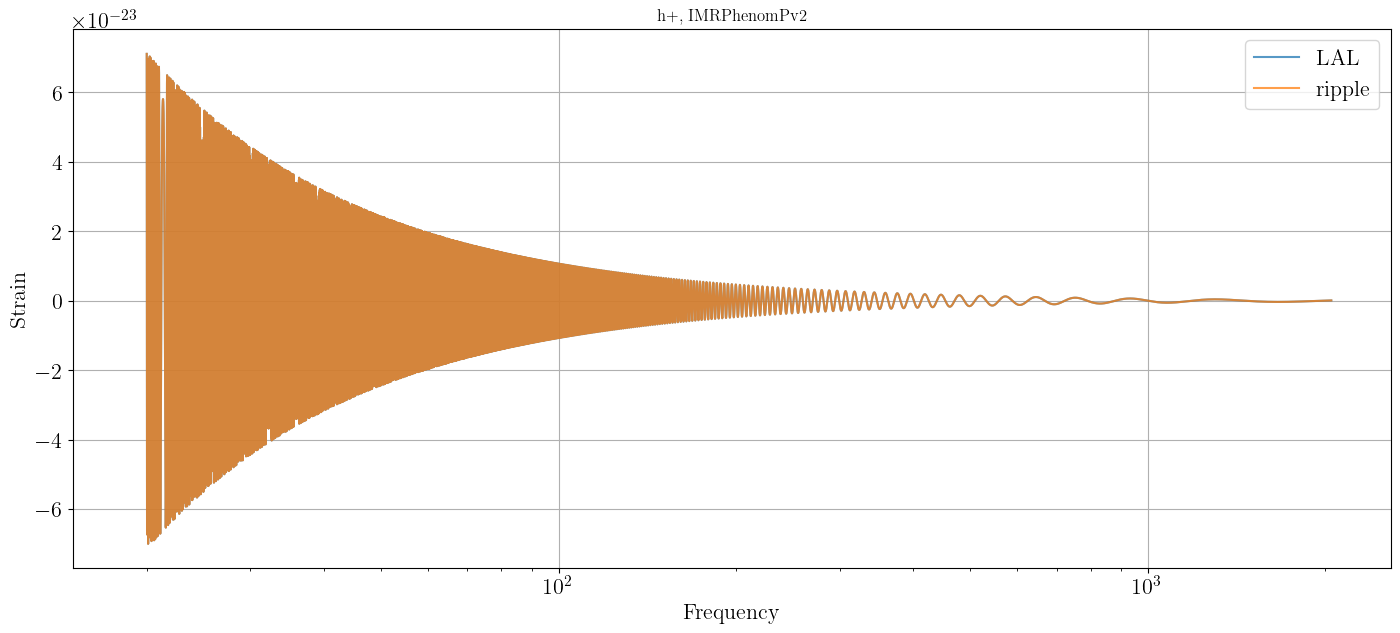

In [8]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7))
# plt.subplot(1, 2, 1)

plt.plot(f, hp_lalsuite.real, "-", label = "LAL", alpha = a)
plt.plot(f, hp_ripple.real, "-", label = "ripple", alpha = a)
plt.title(f"h+, {IMRphenom}")
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.legend()
plt.show()

Amplitude and phase separately

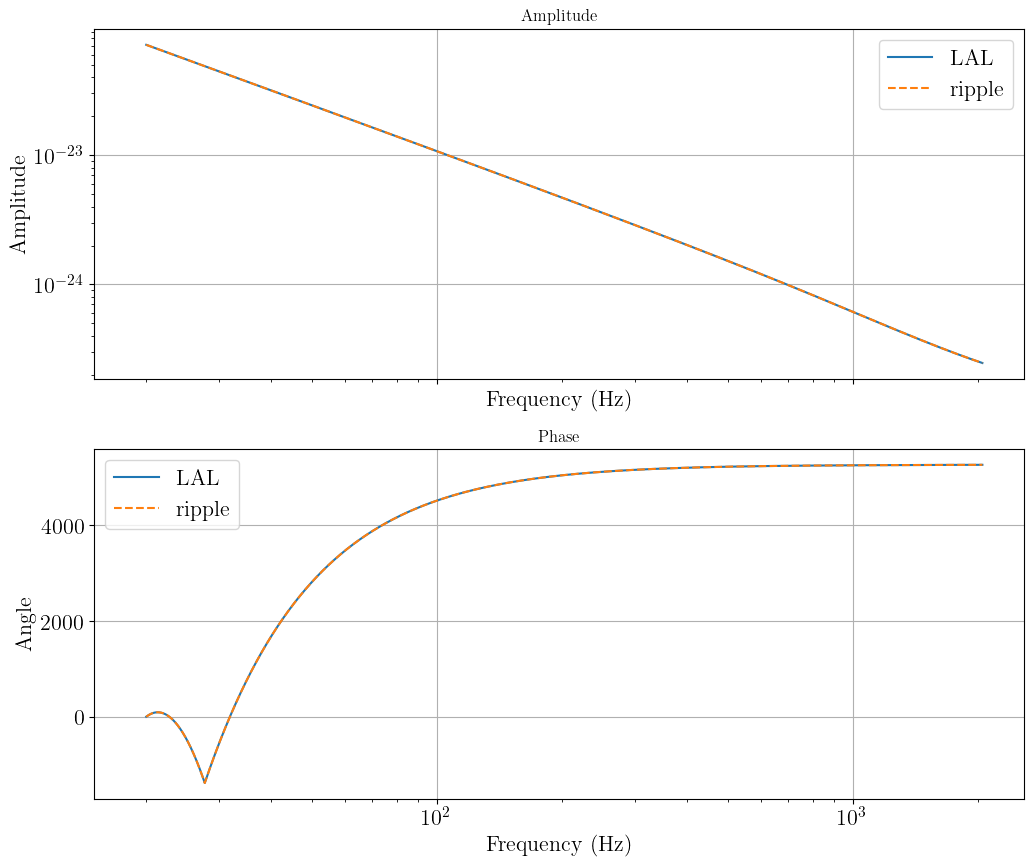

In [9]:
A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite))
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))
phase_ripple = hp_ripple / A_ripple

# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(freqs_lal[mask_lal], A_lalsuite, "-", label = "LAL")
plt.plot(fs_ripple, A_ripple, "--", label = "ripple")

plt.title(r"Amplitude")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, angle_ripple, "--", label = "ripple")
    name = "Angle"
else:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, phase_ripple, "--", label = "ripple")
    name = "Phase"
plt.legend()
plt.title(r"Phase")
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.show()

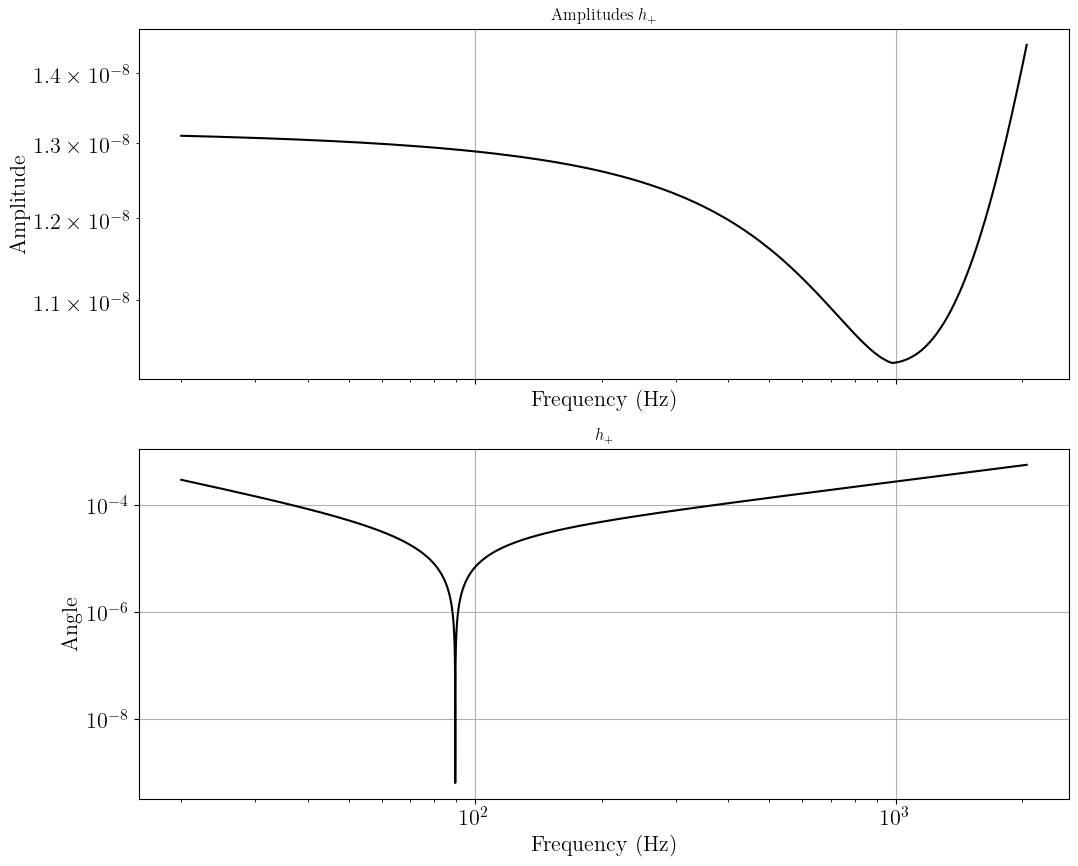

In [10]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_lalsuite - A_ripple) / A_lalsuite
plt.plot(f, diffs_amplitude, "-", color = 'black')

plt.title(r"Amplitudes $h_+$")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs(angle_lalsuite - angle_ripple), "-", color = 'black')
name = "Angle"
# plt.legend()
plt.title(r"$h_+$")
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
# plt.xlim(f_l - 5, 1.2 * f_merger + 20)
plt.yscale('log')
plt.show()

## Computing mismatch

In [11]:
pad_low, pad_high = get_eff_pads(f)
PSD_vals = np.interp(f, f_ASD, ASD) ** 2

match = get_match_arr(
        pad_low,
        pad_high,
        # np.ones_like(fs) * 1.0e-42,
        PSD_vals,
        hp_ripple,
        hp_lalsuite,
    )

print(f"Match: {match}")
print(f"Log 10 mismatch: {np.log10(1 - match)}")

Match: 0.9999999982082759
Log 10 mismatch: -8.746728864105963
